### Initiating Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
# Add spark DL
SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell"

In [3]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [4]:
import pyspark
conf = pyspark.SparkConf()

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("assignment").config(conf = conf).getOrCreate()

In [6]:
spark

In [7]:
# Loading the necessary packages

import keras
import tensorflow as tf
#from sparkdl import *
from pyspark.ml.image import ImageSchema

import pandas as pd

Using TensorFlow backend.


### Import the dataframe with the labels

In [11]:
# Reading in the dataframe with the image labels
df = spark.createDataFrame(pd.read_csv('data/validation.csv'))

In [10]:
# Printing the schema of the dataframe
df.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: long (nullable = true)



In [15]:
# Number of rows in our labelled dataset 
df.count()

256707

In [11]:
# View first few rows 
df.show(n=3)

+----------------+------------+---------+----------+
|         ImageID|      Source|LabelName|Confidence|
+----------------+------------+---------+----------+
|0001eeaf4aed83f9|verification| /m/0cmf2|         1|
|0004886b7d043cfd|verification|/m/01g317|         0|
|0004886b7d043cfd|verification|/m/04hgtk|         0|
+----------------+------------+---------+----------+
only showing top 3 rows



In [12]:
# Dropping unnecessary columns for EDA
df=df.drop("Source","Confidence")

In [13]:
df.show(n=10)

+----------------+---------+
|         ImageID|LabelName|
+----------------+---------+
|0001eeaf4aed83f9| /m/0cmf2|
|0004886b7d043cfd|/m/01g317|
|0004886b7d043cfd|/m/04hgtk|
|0004886b7d043cfd| /m/09j2d|
|0004886b7d043cfd|/m/0463sg|
|000595fe6fee6369| /m/07j7r|
|000595fe6fee6369| /m/02xwb|
|000595fe6fee6369| /m/05s2s|
|000595fe6fee6369|/m/0c9ph5|
|000595fe6fee6369| /m/02wbm|
+----------------+---------+
only showing top 10 rows



##### The label names are encoded. We can join them to the label key to determine the names of the labels.

In [13]:
# Loading the dataframe with the actual name of the labels
label_names = spark.createDataFrame(pd.read_csv('class-descriptions-boxable.csv', header = None, names = ["label_id","label_name"]))

FileNotFoundError: [Errno 2] File b'class-descriptions-boxable.csv' does not exist: b'class-descriptions-boxable.csv'

In [15]:
# Printing the schema
label_names.printSchema()

root
 |-- label_id: string (nullable = true)
 |-- label_name: string (nullable = true)



In [26]:
label_names.count()

601

In [ ]:
# Joining df and the actual label names
labelled_df = df.join(label_names, df["LabelName"] == label_names["label_id"])

In [ ]:
# Dropping the repeated column
labelled_df=labelled_df.drop("LabelName")

In [ ]:
# Printing the schema
labelled_df.printSchema()

In [38]:
labelled_df.show(n=3)

+----------------+---------+----------+
|         ImageID| label_id|label_name|
+----------------+---------+----------+
|0071f62f5d703904|/m/02vqfm|    Coffee|
|00e0a53e14bf2447|/m/02vqfm|    Coffee|
|0173241beb1633e9|/m/02vqfm|    Coffee|
+----------------+---------+----------+
only showing top 3 rows



##### Counts for each of 'ImageID' 

We see that some images are mentioned more than once. This means that each image can have more than one label (positive or negative included)

In [19]:
df.groupBy("ImageID").count().orderBy('count', ascending=False).show(n=10)

+----------------+-----+
|         ImageID|count|
+----------------+-----+
|bdb8487ccbb6d988|   25|
|a52964795b0e2475|   25|
|c9beadfaec7b5043|   25|
|8330ba335d902294|   24|
|f243d6d523d3ce1c|   24|
|935acc24545d071a|   24|
|9f8550843e6f1ba6|   24|
|dd56ac13a2c82644|   24|
|ecbbb807ff44e14d|   24|
|97e37ec091a2f6fe|   23|
+----------------+-----+
only showing top 10 rows



In [20]:
df.groupBy("ImageID").count().orderBy('count', ascending=True).show(n=10)

+----------------+-----+
|         ImageID|count|
+----------------+-----+
|0982fd89020fa0a6|    1|
|95f81ef60e96e397|    1|
|d154dfb570a5a9fa|    1|
|ecc92a92a33d164e|    1|
|6988f3ccbb9e861b|    1|
|1404bfed0ed50b6f|    1|
|037ab7989420885f|    1|
|47b9793ae5455082|    1|
|b83bc06fc626598d|    1|
|dc72f9887c9bbf3a|    1|
+----------------+-----+
only showing top 10 rows



#### Label Name Counts

In [ ]:
labelled_df=labelled_df.toPandas()

In [ ]:
# pip install hvplot
import hvplot.pandas
dcounts = labelled_df.label_name.value_counts(normalize=True)
dcounts_df = pd.DataFrame({'label': dcounts.index.tolist(), 'pct_of_images': dcounts})
dcounts_df.reset_index(drop=True, inplace=True)
dcounts_df[0:50].hvplot.bar(x='label', y='pct_of_images', invert=True, flip_yaxis=True, 
                            height=600, width=600, ylim=(0,0.12))

In [9]:
images = labelled_df.groupby('ImageID').count()
images.columns = ['label_id_Count', 'label_name_Count']
display(images.sort_values('label_id_Count', ascending=False).head(10))
images.hvplot.hist('label_id_Count', bins=50, height=400, width=600)

NameError: name 'labelled_df' is not defined

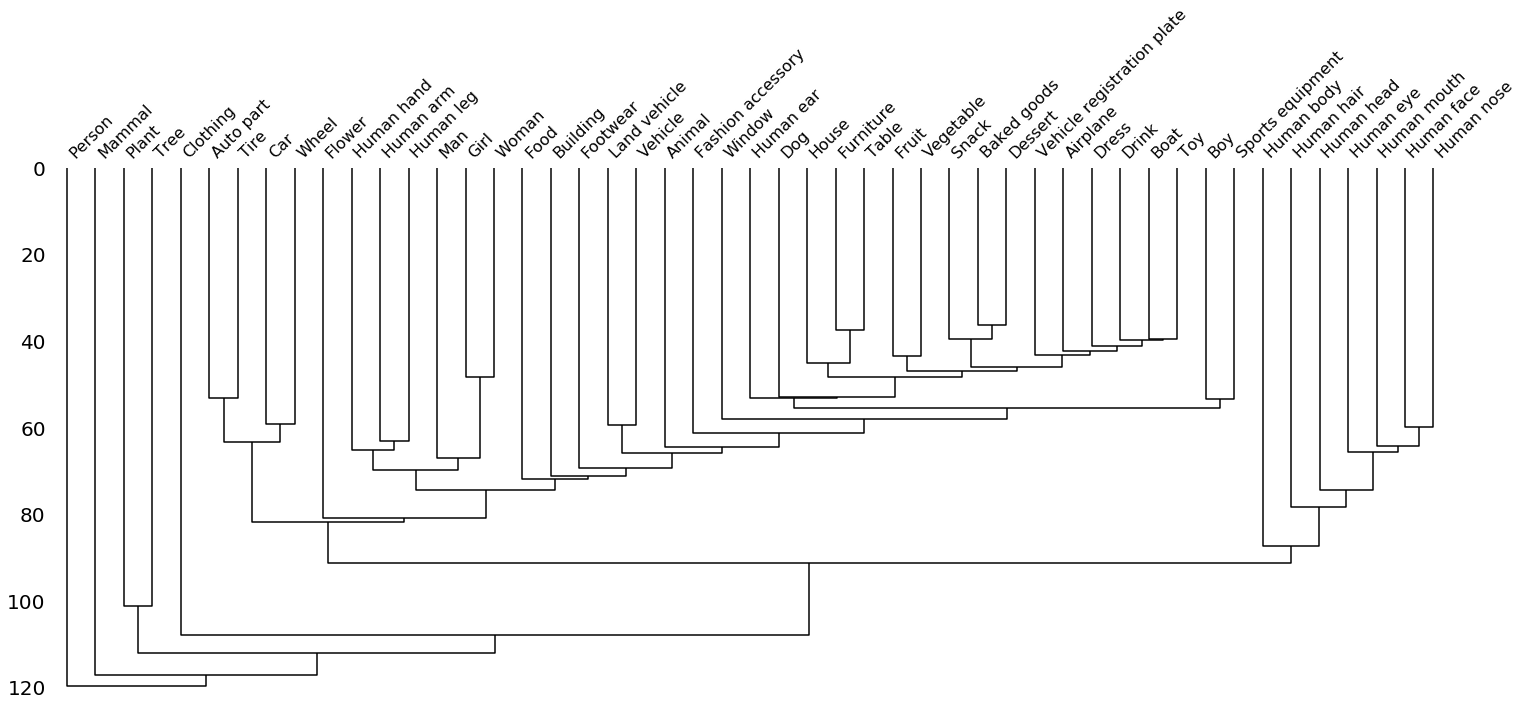

In [25]:
# pip install missingno
import missingno as msno

test = labelled_df[labelled_df.label_name.isin(dcounts_df.loc[0:48,'label'])]
trainpiv = test.pivot_table(index='ImageID', columns='label_name', aggfunc='size')
msno.dendrogram(trainpiv, inline=True)

In [25]:
labelled_df.groupBy("label_name").count().orderBy('count',ascending = False).show()

+-----------+-----+
| label_name|count|
+-----------+-----+
|     Mammal|13153|
|     Person|13081|
|      Plant|12484|
|   Clothing|11286|
| Human head| 9357|
|       Tree| 8561|
| Human body| 8430|
| Human hair| 7592|
| Human nose| 6914|
|        Car| 6534|
|  Human eye| 6363|
|      Wheel| 6109|
| Human face| 5749|
|Human mouth| 5280|
|  Human arm| 4996|
|        Man| 4947|
|      Woman| 4852|
|     Flower| 4586|
| Human hand| 3863|
|  Auto part| 3811|
+-----------+-----+
only showing top 20 rows



### Distribution of labels in dataset in log scale

#### Import actual images

In [20]:
from pyspark.ml.image import ImageSchema
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
import tempfile

In [21]:
from pyspark.sql.functions import lit

In [22]:
# Reading in with labels
from sparkdl.image import imageIO
imagesDF = imageIO.readImagesWithCustomFn("s3://open-images-dataset/validation", decode_f=imageIO.PIL_decode)

In [121]:
type(imagesDF)

pyspark.sql.dataframe.DataFrame

In [122]:
imagesDF.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)



In [46]:
imagesDF.count()

41620

In [23]:
# Extracting id from image origin
imagesDF = imagesDF.select("image").withColumn('id', imagesDF['image.origin'].substr(37, 16))

The dimensions of each images are as follows :

In [24]:
imagesDF.select("image.height","image.width","image.nChannels").head()

Row(height=768, width=1024, nChannels=3)

In [25]:
type(imagesDF)

pyspark.sql.dataframe.DataFrame

In [26]:
imagedim=imagesDF.select("image.height", "image.width")

In [27]:
imagedim.head()

Row(height=1024, width=682)

In [28]:
import hvplot.pandas
sizes = imagedim.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
imagedim.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

AttributeError: 'GroupedData' object has no attribute 'size'

In [67]:
imagesDF.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- id: string (nullable = true)



In [88]:
imagesDF_joined.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- id: string (nullable = true)
 |-- ImageID: string (nullable = true)
 |-- label_id: string (nullable = true)
 |-- label_name: string (nullable = true)



In [99]:
spark.stop()